# Exporting American Movie Adaptations 

## MVP

#### **Analysis Goal**

The (fictitious) international movie distributor, Movies Worldwide, Inc., has requested a model to inform their choice of which American box office hits to export. 
The [original source for adaptation](https://stephenfollows.com/highest-grossing-movie-adaptations/) can influence its success. 

They have seen the press from the last few years, which reports that [book adaptations earn more worldwide at the box office](https://www.forbes.com/sites/adamrowe1/2018/07/11/why-book-based-films-earn-53-more-at-the-worldwide-box-office/?sh=290c1dfc306f). And a small [2020 survey](https://www.bhg.com/news/book-vs-movie-debate/) of Americans which found that respondents almost equally enjoyed the book as much as a movie adaptation. 

Certain artistic qualities make [book to movie](https://news.northeastern.edu/2012/03/27/kelly/) adaptations successful, but they can be subjective and are harder to model. 

There are [super earning book-to-film adaptations](https://filmthreat.com/features/what-makes-a-book-to-film-adaptation-so-successful/) which followed super earning book launches, such as the *Harry Potter* series and *Lord of the Rings*. 

Our client's niche market is to export movies with more affordable movie distribution rights. Our task is to build a model using available data for high gross earning movies abroad and use that model to predict lesser-known movie adaptations to recommend to export.  
  

#### **Process**

Scraped data for movie adaptations from boxofficemojo.com. Adaptations include:
* books<sup>1</sup>
* television shows<sup>2</sup>
* events, 
* video games, and 
* plays. 

Created a linear regression model (ordinary least squares) with one feature,`domestic_total_gross`, to predict the `international_total_gross`. The model has an adjusted R<sup>2</sup> of 0.763. 

#### **Preliminary Visualization**
The linear regression model plot shows that the model does not capture the data well enough to make accurate predictions. The data points are clustered close to the origin of the graph. 

#### **Preliminary Conclusions**
Movies with high revenues highly impact the predictive power of the model. The residual plot indicates heteroskedasticity which is likely due to the wide range of domestic movie revenue (\\$742 - \\$543,638,043).
<br></br>
<br></br>
<sup>1</sup> Books include young adult novels, contemporary novels, children's books, and comic books. 

<sup>2</sup> Television shows include children shows and cartoons.  


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline


### 1. [Scraped ](https://github.com/slp22/regression-project/blob/main/adaptation_movies_data_acquisition.ipynb) and [Cleaned](https://github.com/slp22/regression-project/blob/main/adaptation_movies_eda.ipynb) Movie Adaptations DataFrame

In [2]:
movie_df = pd.read_csv('clean_df.csv')
movie_df.head()

,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,international_total_gross,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating,link_stub
0,543638043,6,The Lion King,4802,4725,1119261396,1662899439,191770759,260000000,2019-07-11,118.0,Walt Disney Studios Motion Pictures,Adventure Animation Drama Family Musical,PG,/title/tt6105098/?ref_=bo_ge_table_6
1,534987076,7,The Dark Knight,4366,4366,471115201,1006102277,158411483,185000000,2008-07-16,152.0,Warner Bros.,Action Crime Drama Thriller,PG-13,/title/tt0468569/?ref_=bo_ge_table_7
2,504481165,8,Beauty and the Beast,4210,4210,769095055,1273576220,174750616,160000000,2017-03-16,129.0,Walt Disney Studios Motion Pictures,Adventure Family Fantasy Musical Romance,PG,/title/tt2771200/?ref_=bo_ge_table_8
3,459005868,9,Avengers: Age of Ultron,4276,4276,943803672,1402809540,191271109,250000000,2015-04-22,141.0,Walt Disney Studios Motion Pictures,Action Adventure Sci-Fi,PG-13,/title/tt2395427/?ref_=bo_ge_table_9
4,448149584,10,The Dark Knight Rises,4404,4404,633003513,1081153097,160887295,250000000,2012-07-19,164.0,Warner Bros.,Action Crime Drama,PG-13,/title/tt1345836/?ref_=bo_ge_table_10


In [3]:
movie_df.sort_values('domestic_total_gross', ascending=True) 
movie_df.head(2)
# max $543,638,043

,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,international_total_gross,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating,link_stub
0,543638043,6,The Lion King,4802,4725,1119261396,1662899439,191770759,260000000,2019-07-11,118.0,Walt Disney Studios Motion Pictures,Adventure Animation Drama Family Musical,PG,/title/tt6105098/?ref_=bo_ge_table_6
1,534987076,7,The Dark Knight,4366,4366,471115201,1006102277,158411483,185000000,2008-07-16,152.0,Warner Bros.,Action Crime Drama Thriller,PG-13,/title/tt0468569/?ref_=bo_ge_table_7


In [4]:
movie_df.tail(2)
# min $742

,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,international_total_gross,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating,link_stub
899,809,963,I Spit on Your Grave 2,1,1,677795,678604,441,0,2013-09-05,106.0,Anchor Bay Films,Horror Thriller,R,/title/tt2537176/?ref_=bo_ge_table_63
900,742,964,Amityville: The Awakening,10,10,8481255,8481997,742,0,2017-07-20,87.0,Dimension Films,Horror Thriller,PG-13,/title/tt1935897/?ref_=bo_ge_table_64


### 2. Features Correlation

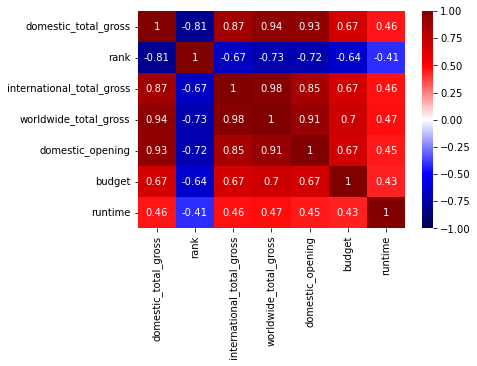

In [5]:
# heatmap
sns.heatmap(movie_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


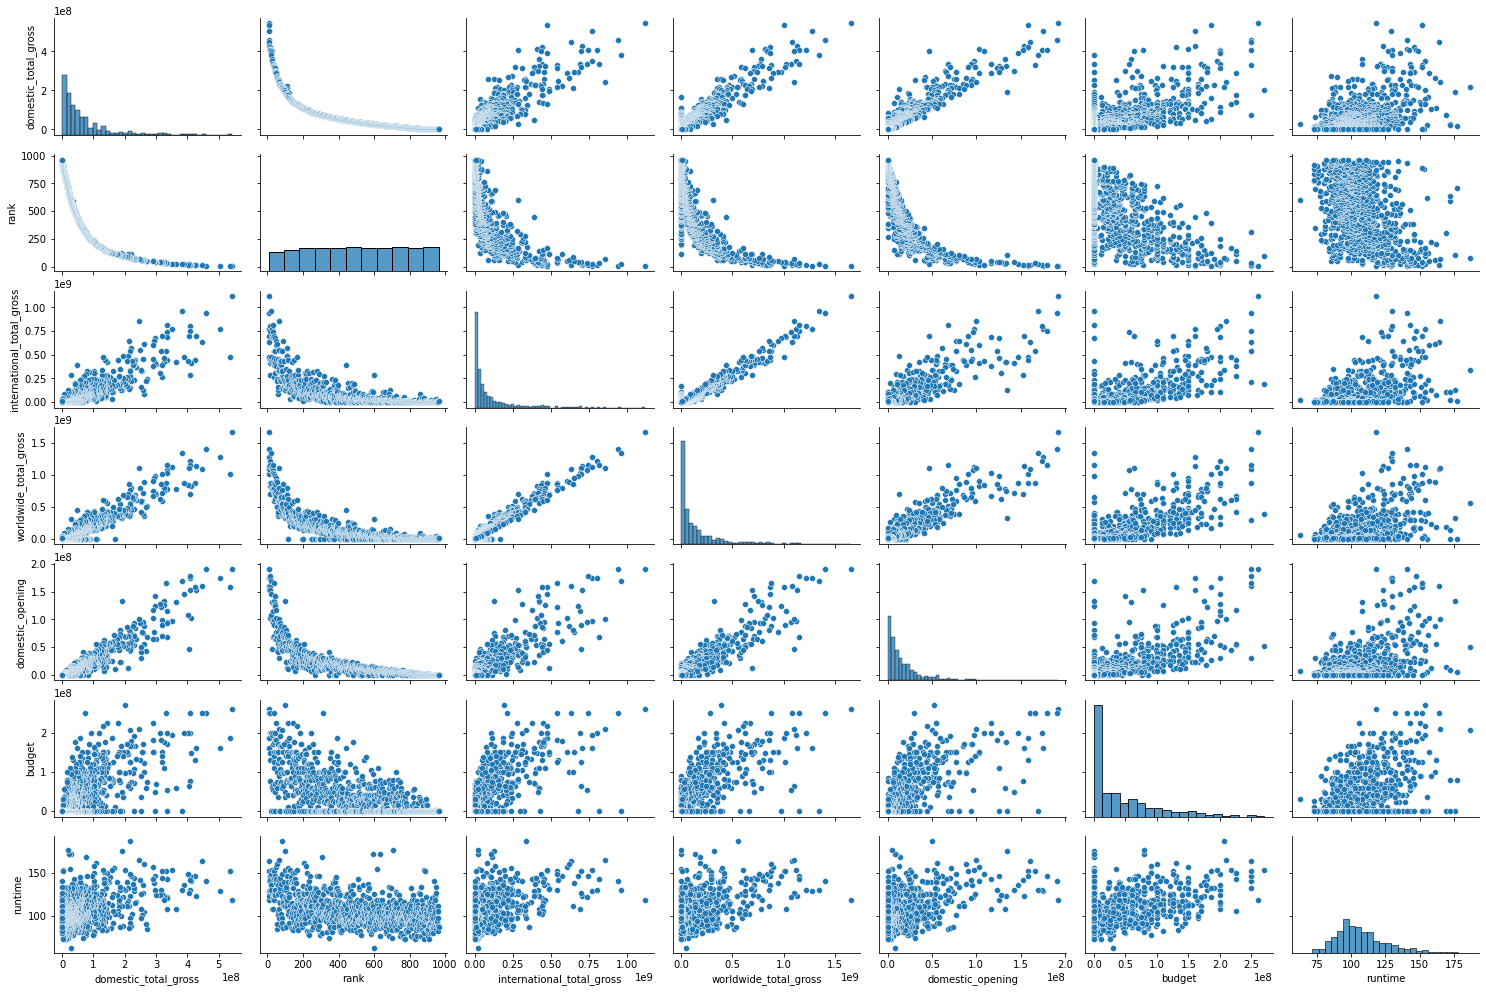

In [6]:
# pairplot
sns.pairplot(movie_df, height=2, aspect=1.5);

### 3. Linear Regression Model

In [7]:
## FEAUTRES
# 'domestic_total_gross'
# 'domestic_opening'
# 'budget'
# 'max_theaters'
# 'opening_theathers'
# 'worldwide_total_gross' # wtg = domestic_total_gross + international_total_gross; candidate for multicollinearity

## TARGET
# 'international_total_gross'

# y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + domestic_opening + budget + worldwide_total_gross', data=movie_df, return_type="dataframe")
# y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + domestic_opening + budget',                         data=movie_df, return_type="dataframe")
# y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + domestic_opening',                                  data=movie_df, return_type="dataframe")
# y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross + budget',                                            data=movie_df, return_type="dataframe")
y, X = patsy.dmatrices('international_total_gross ~ domestic_total_gross',                                                     data=movie_df, return_type="dataframe")

# model
model = sm.OLS(y, X)

# fit model
fit = model.fit()

# model performance statistics
fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     international_total_gross   R-squared:                       0.764
Model:                                   OLS   Adj. R-squared:                  0.763
Method:                        Least Squares   F-statistic:                     2903.
Date:                       Sun, 13 Mar 2022   Prob (F-statistic):          9.44e-284
Time:                               20:05:33   Log-Likelihood:                -17572.
No. Observations:                        901   AIC:                         3.515e+04
Df Residuals:                            899   BIC:                         3.516e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.173e+07   3.06e+06     -3.831      0.000   -1.77e+07   -5.72e+06
domestic_total_gross     1.5312      0.028     53.881      0.000       1.475       1.587
==============================================================================
Omnibus:                      281.523   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2517.116
Skew:                           1.158   Prob(JB):                         0.00
Kurtosis:                      10.854   Cond. No.                     1.38e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4. Model Visualization


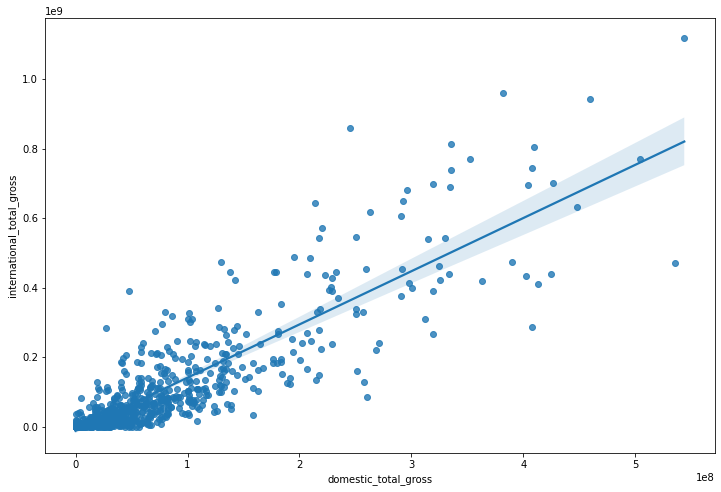

In [8]:
# linear regression plot
f, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x='domestic_total_gross', y='international_total_gross', data=movie_df);


### 5. Residuals Plot

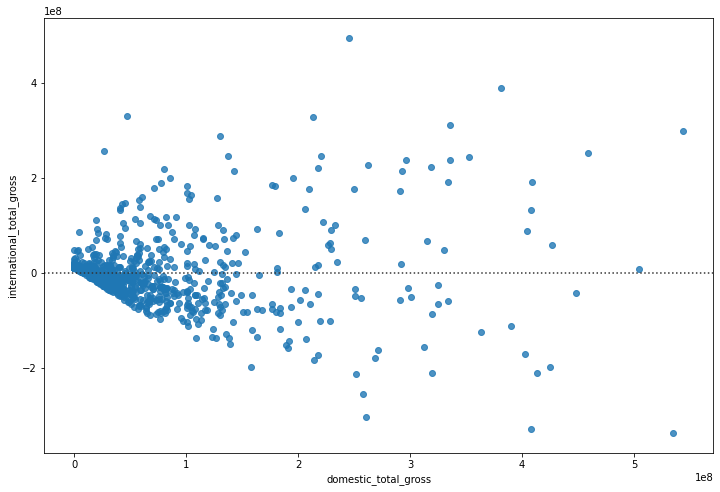

In [9]:
# cone shape indicates heteroskedasticity; likely due to the large range of domestic movie revenue
f, ax = plt.subplots(figsize=(12, 8))
sns.residplot(x='domestic_total_gross', y='international_total_gross', data=movie_df);
